In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pandas import Series
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
# reading data
train= pd.read_csv("Train_SU63ISt.csv")
test= pd.read_csv("Test_0qrQsBZ.csv")

In [3]:
# Copying both train and test sets
train_original= train.copy()
test_original= test.copy()

## Hypothesis statement
1. Traffic will increase with time
2. Traffic will be high from May to Oct
3. Traffic o weekdays will be more
4. Traffic during the peak hours will be high

In [4]:
# Understanding data
train.columns, test.columns

(Index(['ID', 'Datetime', 'Count'], dtype='object'),
 Index(['ID', 'Datetime'], dtype='object'))

In [6]:
train.dtypes, test.dtypes

(ID           int64
 Datetime    object
 Count        int64
 dtype: object,
 ID           int64
 Datetime    object
 dtype: object)

In [7]:
train.shape, test.shape

((18288, 3), (5112, 2))

In [4]:
# Feature Extraction
train['Datetime']= pd.to_datetime(train.Datetime, format='%d-%m-%Y %H:%M')
test['Datetime']= pd.to_datetime(test.Datetime, format='%d-%m-%Y %H:%M')
test_original['Datetime'] = pd.to_datetime(test_original.Datetime,format='%d-%m-%Y %H:%M')
train_original['Datetime'] = pd.to_datetime(train_original.Datetime, format='%d-%m-%Y %H:%M')

In [5]:
# extracting date and time components
for i in (train, test, test_original, train_original):
    i['year']= i.Datetime.dt.year
    i['month']= i.Datetime.dt.month
    i['day']= i.Datetime.dt.day
    i['Hour']= i.Datetime.dt.hour

In [6]:
# extracting dayofweek
train['day of week']= train['Datetime'].dt.dayofweek

In [7]:
# extracting weekend
def applyer(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1
    else:
        return 0
train['weekend']= train['Datetime'].apply(applyer)

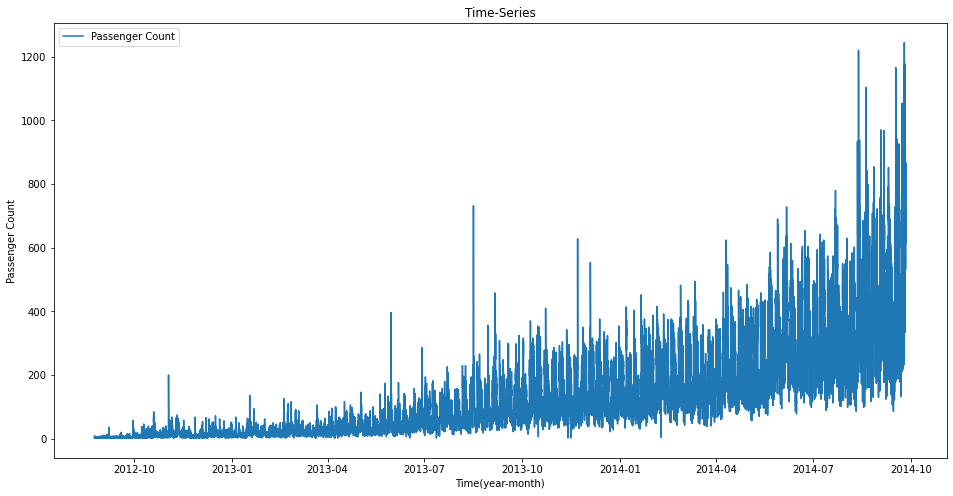

In [8]:
# plotting time-series
train.index= train['Datetime']    #indexing to get datettime on x-axis
df= train.drop('ID', axis=1)      #dropping id variable
ts= df['Count']
plt.figure(figsize=(16,8))
plt.plot(ts, label='Passenger Count')
plt.title('Time-Series')
plt.xlabel('Time(year-month)')
plt.ylabel('Passenger Count')
plt.legend(loc='best')

<AxesSubplot:xlabel='year'>

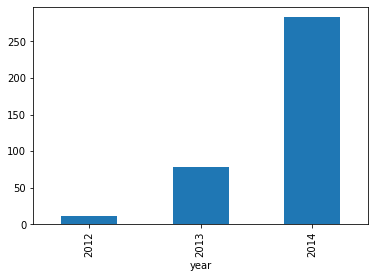

In [9]:
# Exploratory Analysis
train.groupby('year')['Count'].mean().plot.bar()

<AxesSubplot:xlabel='month'>

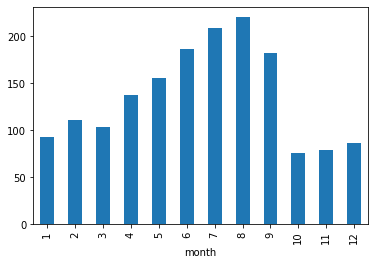

In [10]:
train.groupby('month')['Count'].mean().plot.bar()

<AxesSubplot:title={'center':'Passenger Count (Monthwise)'}, xlabel='year,month'>

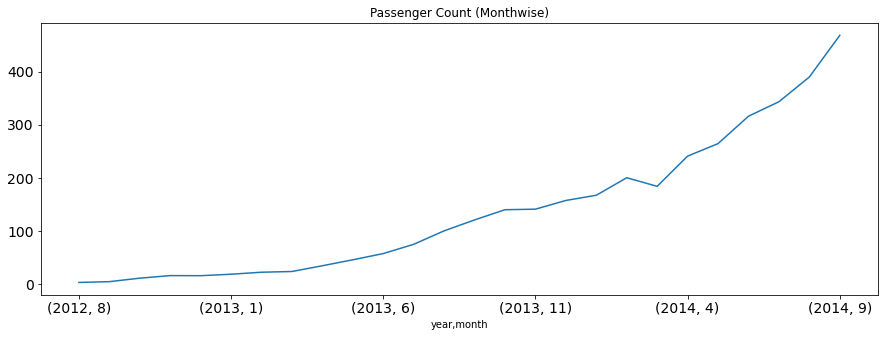

In [11]:
temp= train.groupby(['year','month'])['Count'].mean()
temp.plot(figsize=(15,5), title= 'Passenger Count (Monthwise)', fontsize= 14)

<AxesSubplot:xlabel='day'>

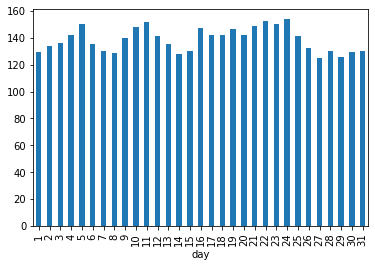

In [12]:
train.groupby('day')['Count'].mean().plot.bar()

<AxesSubplot:xlabel='Hour'>

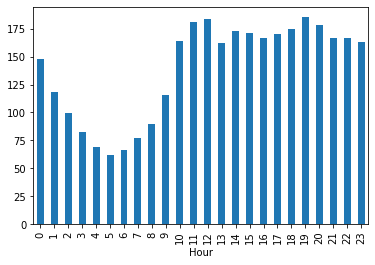

In [13]:
train.groupby('Hour')['Count'].mean().plot.bar()

<AxesSubplot:xlabel='weekend'>

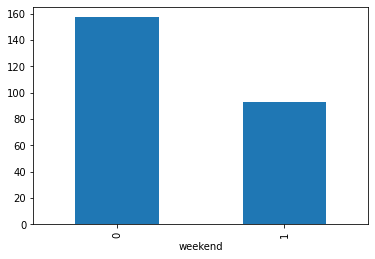

In [14]:
train.groupby('weekend')['Count'].mean().plot.bar()

<AxesSubplot:xlabel='day of week'>

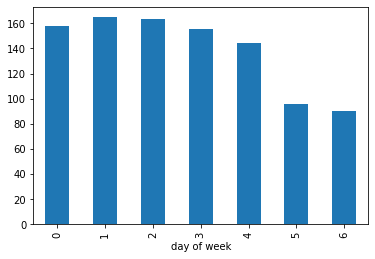

In [15]:
train.groupby('day of week')['Count'].mean().plot.bar()

In [16]:
train= train.drop('ID', axis=1)

In [17]:
# converting hourly to daily, weekly, monthly series to reduce noise
train.Timestamp= pd.to_datetime(train.Datetime, format='%d-%m-%Y %H:%M')
train.index= train.Timestamp

# Hourly mean
hourly= train.resample('H').mean()

# Daily mean
daily= train.resample('D').mean()

# Weekly mean
weekly= train.resample('W').mean()

# Monthly mean
monthly= train.resample('M').mean()

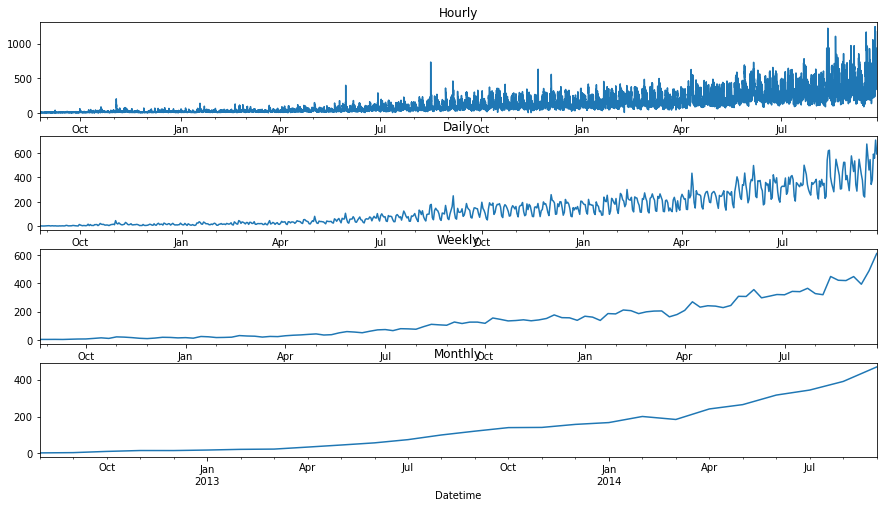

In [18]:
# Plotting
fig, axs= plt.subplots(4,1)
hourly.Count.plot(figsize= (15,8), title= 'Hourly', ax= axs[0])
daily.Count.plot(figsize= (15,8), title= 'Daily', ax= axs[1])
weekly.Count.plot(figsize= (15,8), title= 'Weekly', ax= axs[2])
monthly.Count.plot(figsize= (15,8), title= 'Monthly', ax= axs[3])
plt.show()

In [19]:
# Working with daily time series
train.Timestamp= pd.to_datetime(train.Datetime, format='%d-%m-%Y %H:%M')
train.index= train.Timestamp
train= train.resample('D').mean()

test.Timestamp= pd.to_datetime(test.Datetime, format='%d-%m-%Y %H:%M')
test.index= test.Timestamp
test= test.resample('D').mean()

In [20]:
# Train- Validation set split (21 months:3 months)
Train= train.loc['2012-08-25': '2014-06-24']
Valid= train.loc['2014-06-25': '2014-09-25']

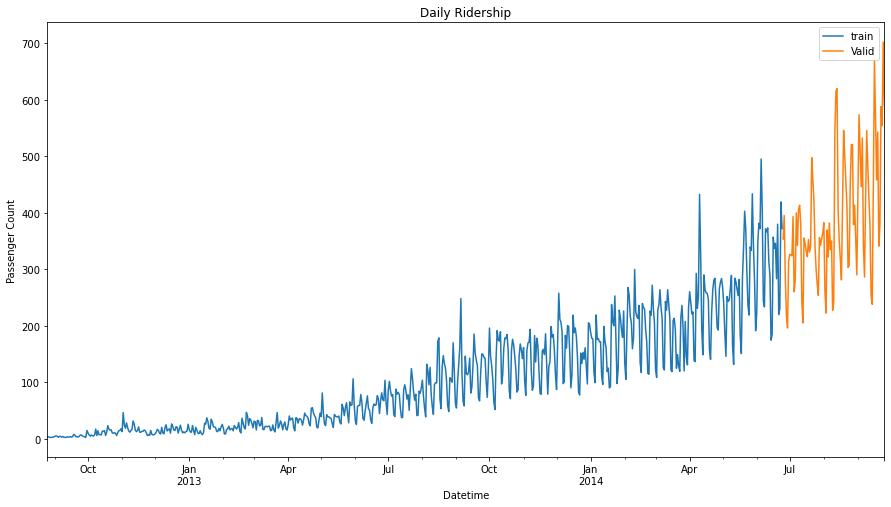

In [21]:
# plotting
Train.Count.plot(figsize= (15,8), title= 'Daily Ridership', label= 'train')
Valid.Count.plot(figsize= (15,8), title= 'Daily Ridership', label= 'Valid')
plt.xlabel('Datetime')
plt.ylabel('Passenger Count')
plt.legend(loc= 'best')
plt.show()

## Modelling Techniques to be used
1. Naive Approach
2. Moving Average
3. Simple Exponential Smoothing
4. Holt's Linear Trend Model

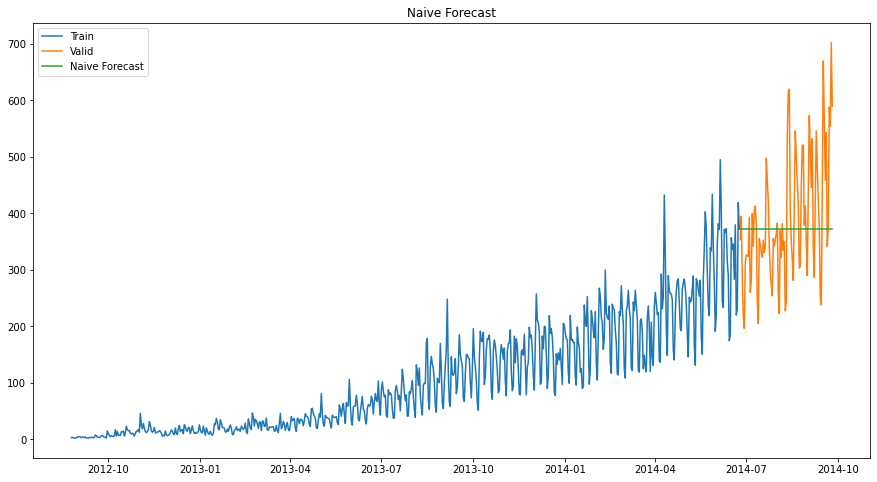

In [22]:
# Naive's Approach
dd= np.asarray(Train.Count)
y_hat= Valid.copy()
y_hat['Naive']= dd[len(dd)-1]
plt.figure(figsize= (15,8))
plt.plot(Train.index, Train['Count'], label= 'Train')
plt.plot(Valid.index, Valid['Count'], label= 'Valid')
plt.plot(y_hat.index, y_hat['Naive'], label= 'Naive Forecast')
plt.legend(loc= 'best')
plt.title('Naive Forecast')
plt.show()

In [23]:
# RMSE on validation set
from sklearn.metrics import mean_squared_error
from math import sqrt
rms= sqrt(mean_squared_error(Valid.Count, y_hat.Naive))
print(rms)

111.79050467496724


High RMSE value!

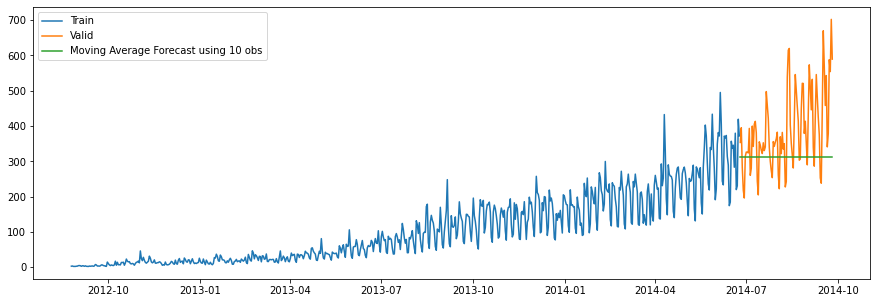

In [24]:
# Moving Average for last 10, 20, 50 observations
y_hat_avg= Valid.copy()
y_hat_avg['moving_avg_forecast']= Train.Count.rolling(10).mean().iloc[-1]    # Rolling Mean for Last 10 observations
plt.figure(figsize=(15,5))
plt.plot(Train['Count'], label= 'Train')
plt.plot(Valid['Count'], label= 'Valid')
plt.plot(y_hat_avg['moving_avg_forecast'], label= 'Moving Average Forecast using 10 obs')
plt.legend(loc= 'best')
plt.show()

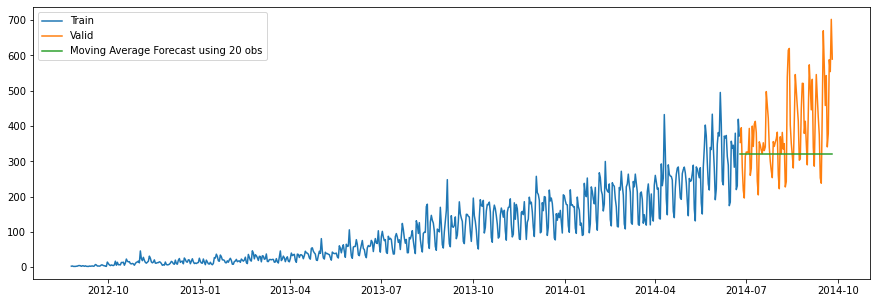

In [25]:
y_hat_avg= Valid.copy()
y_hat_avg['moving_avg_forecast']= Train.Count.rolling(20).mean().iloc[-1]    # Rolling Mean for Last 10 observations
plt.figure(figsize=(15,5))
plt.plot(Train['Count'], label= 'Train')
plt.plot(Valid['Count'], label= 'Valid')
plt.plot(y_hat_avg['moving_avg_forecast'], label= 'Moving Average Forecast using 20 obs')
plt.legend(loc= 'best')
plt.show()

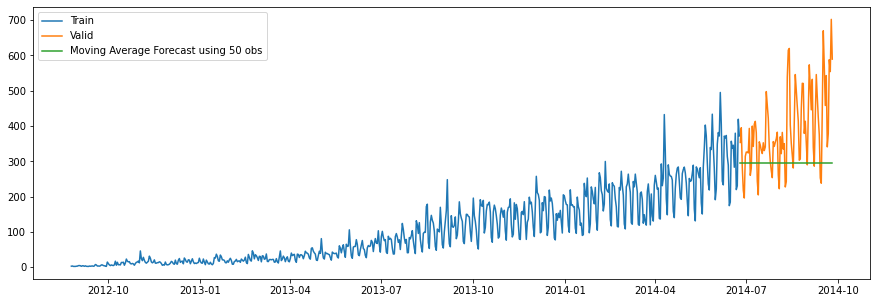

In [26]:
y_hat_avg= Valid.copy()
y_hat_avg['moving_avg_forecast']= Train.Count.rolling(50).mean().iloc[-1]    # Rolling Mean for Last 10 observations
plt.figure(figsize=(15,5))
plt.plot(Train['Count'], label= 'Train')
plt.plot(Valid['Count'], label= 'Valid')
plt.plot(y_hat_avg['moving_avg_forecast'], label= 'Moving Average Forecast using 50 obs')
plt.legend(loc= 'best')
plt.show()

In [27]:
rms= sqrt(mean_squared_error(Valid.Count, y_hat_avg['moving_avg_forecast']))
print(rms)

144.19175679986793


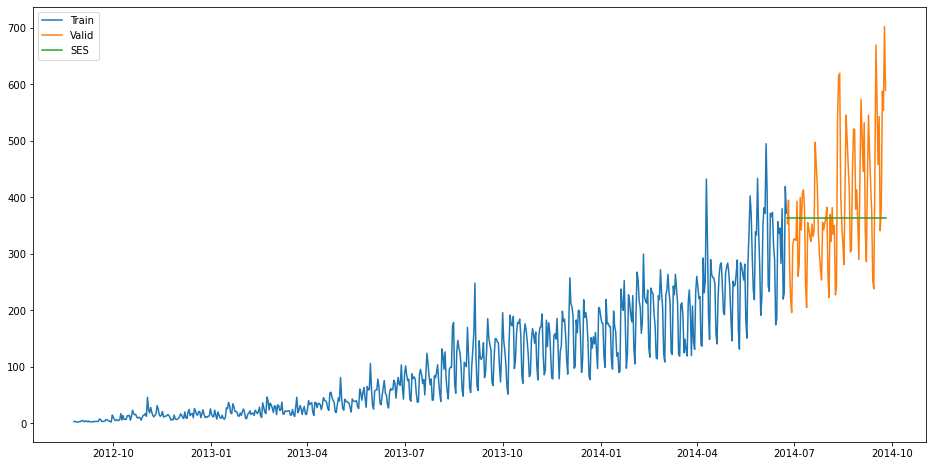

In [28]:
# Simple Exponential Smoothing
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

y_hat_avg= Valid.copy()
fit2= SimpleExpSmoothing(np.asarray(Train['Count'])).fit(smoothing_level=0.6, optimized=False)
y_hat_avg['SES']= fit2.forecast(len(Valid))
plt.figure(figsize=(16,8))
plt.plot(Train['Count'], label= 'Train')
plt.plot(Valid['Count'], label= 'Valid')
plt.plot(y_hat_avg['SES'], label= 'SES')
plt.legend(loc= 'best')
plt.show()

In [29]:
rms= sqrt(mean_squared_error(Valid.Count, y_hat_avg['SES']))
print(rms)

113.43708111884514


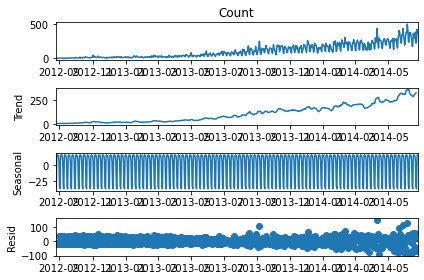

In [30]:
# Holt's Linear Trend Model

# Visualising Trend, Seasonality and Error in the series
import statsmodels.api as sm

sm.tsa.seasonal_decompose(Train.Count).plot()
results= sm.tsa.stattools.adfuller(Train.Count)
plt.show()

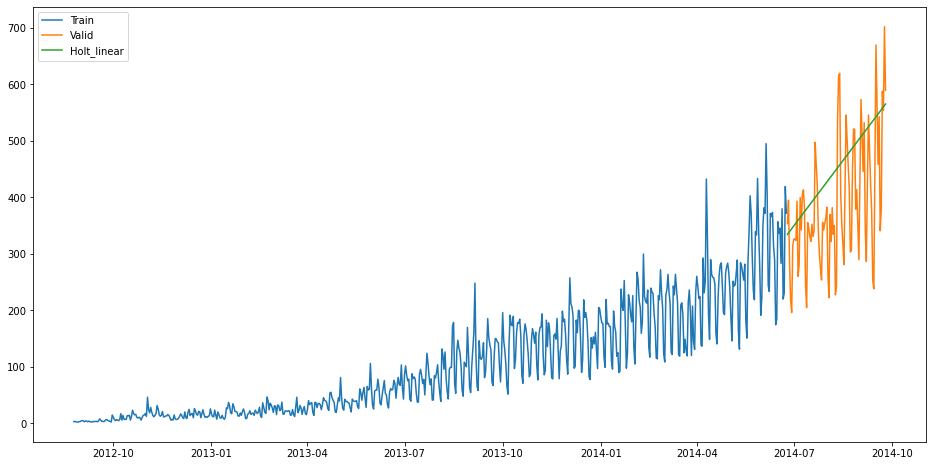

In [31]:
# Building model based on increasing trend
y_hat_avg= Valid.copy()
fit1= Holt(np.asarray(Train['Count'])).fit(smoothing_level=0.3, smoothing_slope=0.1)
y_hat_avg['Holt_linear']= fit1.forecast(len(Valid))
plt.figure(figsize=(16,8))
plt.plot(Train['Count'], label= 'Train')
plt.plot(Valid['Count'], label= 'Valid')
plt.plot(y_hat_avg['Holt_linear'], label= 'Holt_linear')
plt.legend(loc= 'best')
plt.show()

In [32]:
rms= sqrt(mean_squared_error(Valid.Count, y_hat_avg['Holt_linear']))
print(rms)

112.94278345314041


In [33]:
# Predictions on Test Dataset (daily time-series)
test['predict']= fit1.forecast(len(test))

In [34]:
# converting daily predictions to hourly basis

# calculating hourly ratio of count
train_original['ratio']= train_original['Count']/train_original['Count'].sum()

# grouping the hourly ratio
temp= train_original.groupby(['Hour'])['ratio'].sum()

# to csv format
pd.DataFrame(temp, columns= ['Hour', 'ratio']).to_csv('GROUPby.csv')
temp2= pd.read_csv('GROUPby.csv')
temp2= temp2.drop('Hour.1', 1)

# Merging Test and Test_original on day, month and year
merge= pd.merge(test, test_original, on=('day', 'month', 'year'), how= 'left')
merge['Hour']= merge['Hour_y']
merge= merge.drop(['year', 'month', 'Datetime', 'Hour_x', 'Hour_y'], axis=1)

# predicting by merging merge and temp2
prediction= pd.merge(temp2, merge, on='Hour', how='left')

# converting ratio to original scale
prediction['Count']= prediction['predict'] * prediction['ratio'] * 24


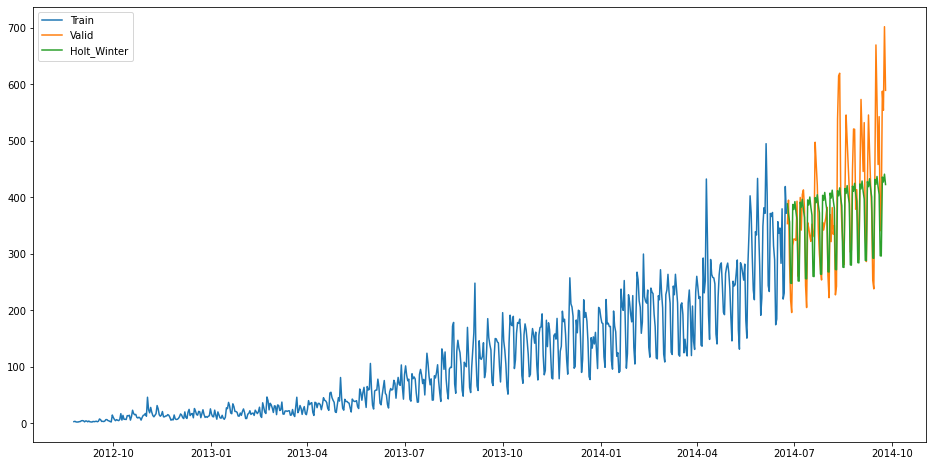

In [35]:
# Holt's Winter model on daily timeseries

y_hat_avg= Valid.copy()
fit1= ExponentialSmoothing(np.asarray(Train['Count']), seasonal_periods=7, trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter']= fit1.forecast(len(Valid))
plt.figure(figsize=(16,8))
plt.plot(Train['Count'], label= 'Train')
plt.plot(Valid['Count'], label= 'Valid')
plt.plot(y_hat_avg['Holt_Winter'], label= 'Holt_Winter')
plt.legend(loc= 'best')
plt.show()

In [36]:
rms= sqrt(mean_squared_error(Valid.Count, y_hat_avg['Holt_Winter']))
print(rms)

79.69954564712181


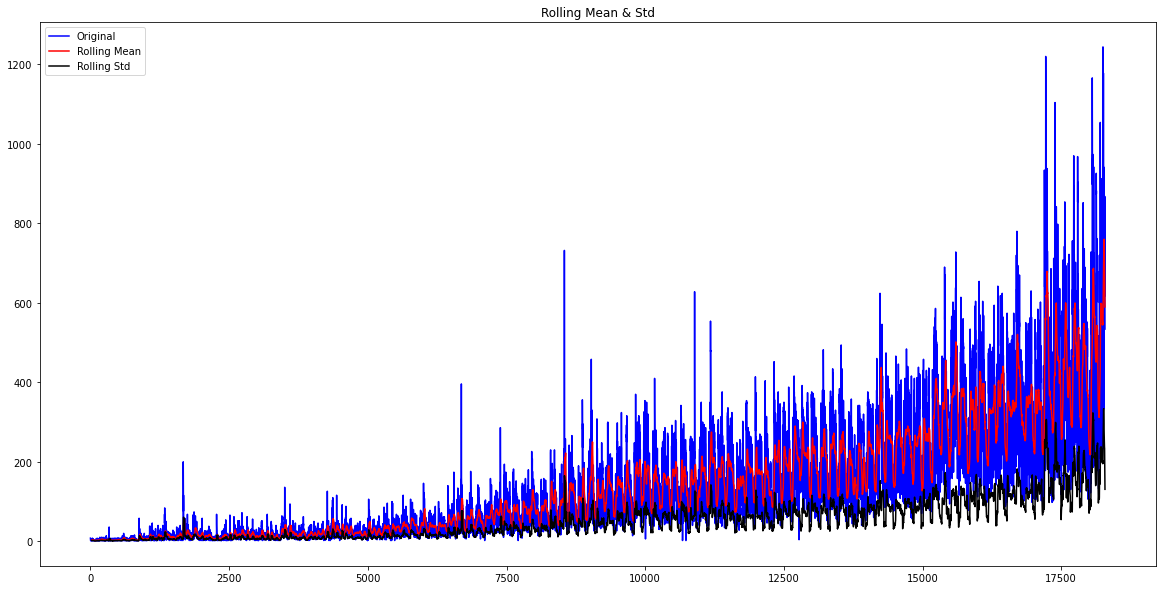

Results of Dickey-fuller tests:
Test Statistic             -4.456561
p-value                     0.000235
#Lags used                 45.000000
No. of obs used         18242.000000
Critical Value (1%)        -3.430709
Critical Value (5%)        -2.861698
Critical Value (10%)       -2.566854
dtype: float64


In [37]:
# ARIMA model

# Stationarity check using Dickey-fuller test
def test_stationarity(train_original):
    rolmean= train_original.rolling(24).mean()    #for last 24 hours
    rolstd= train_original.rolling(24).std()
    
    # plot rolling statistics
    orig= plt.plot(train_original, color='blue', label='Original')
    mean= plt.plot(rolmean, color='red', label='Rolling Mean')
    std= plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Std')
    plt.show(block=False)
    
    # perform Dickey-Fuller Test
    print('Results of Dickey-fuller tests:')
    dftest= sm.tsa.stattools.adfuller(train_original, autolag= 'AIC')
    dfoutput= pd.Series(dftest[0:4], index= ['Test Statistic', 'p-value', '#Lags used', 'No. of obs used'])
    
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
from matplotlib.pylab import rcParams
rcParams['figure.figsize']= 20,10

test_stationarity(train_original['Count'])

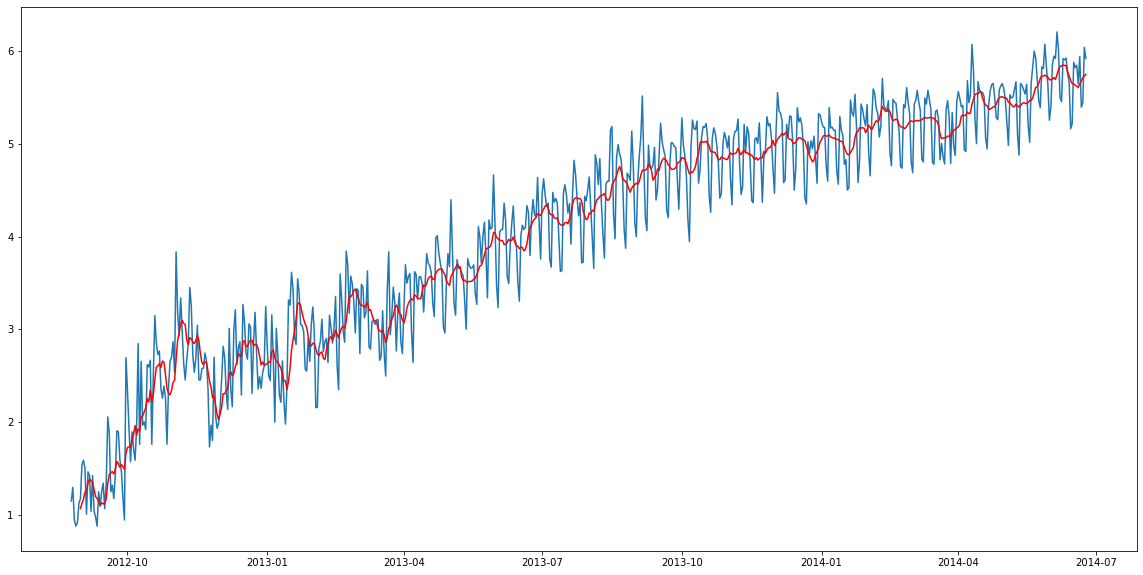

In [39]:
# Making time-series stationary by removing Trend and Seasonality

# removing trend
Train_log= np.log(Train['Count'])
Valid_log= np.log(Valid['Count'])
moving_avg= Train_log.rolling(7).mean()
plt.plot(Train_log)
plt.plot(moving_avg, color='red')
plt.show()

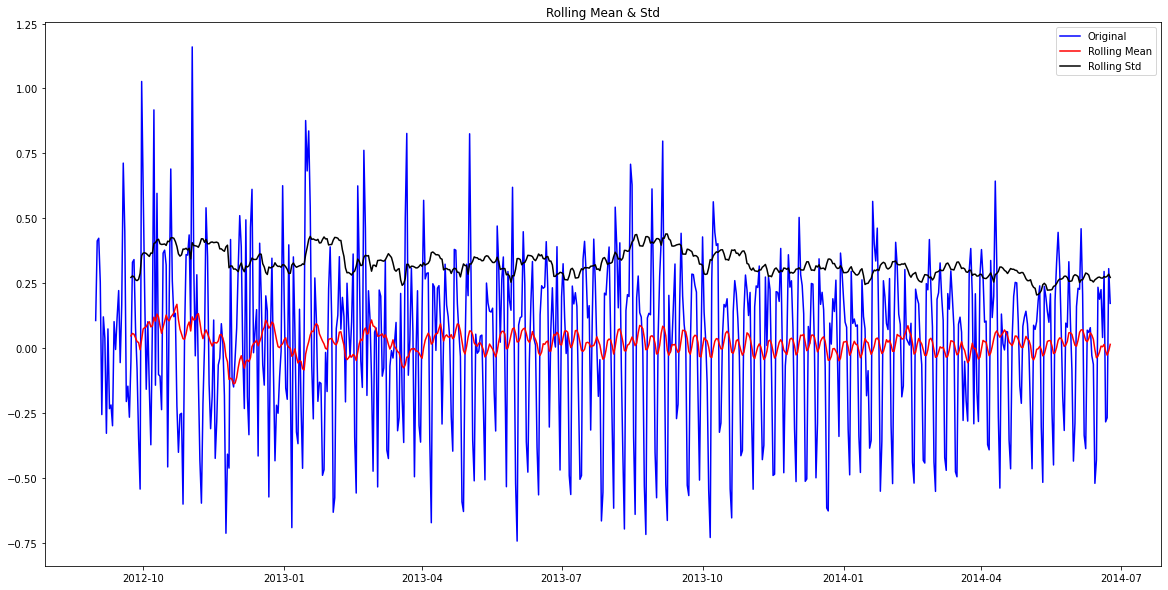

Results of Dickey-fuller tests:
Test Statistic         -6.300865e+00
p-value                 3.414885e-08
#Lags used              2.000000e+01
No. of obs used         6.420000e+02
Critical Value (1%)    -3.440577e+00
Critical Value (5%)    -2.866052e+00
Critical Value (10%)   -2.569173e+00
dtype: float64


In [40]:
Train_log_moving_avg_diff= Train_log - moving_avg
Train_log_moving_avg_diff.dropna(inplace= True)    # dropping null values (first 23 obs)
test_stationarity(Train_log_moving_avg_diff)

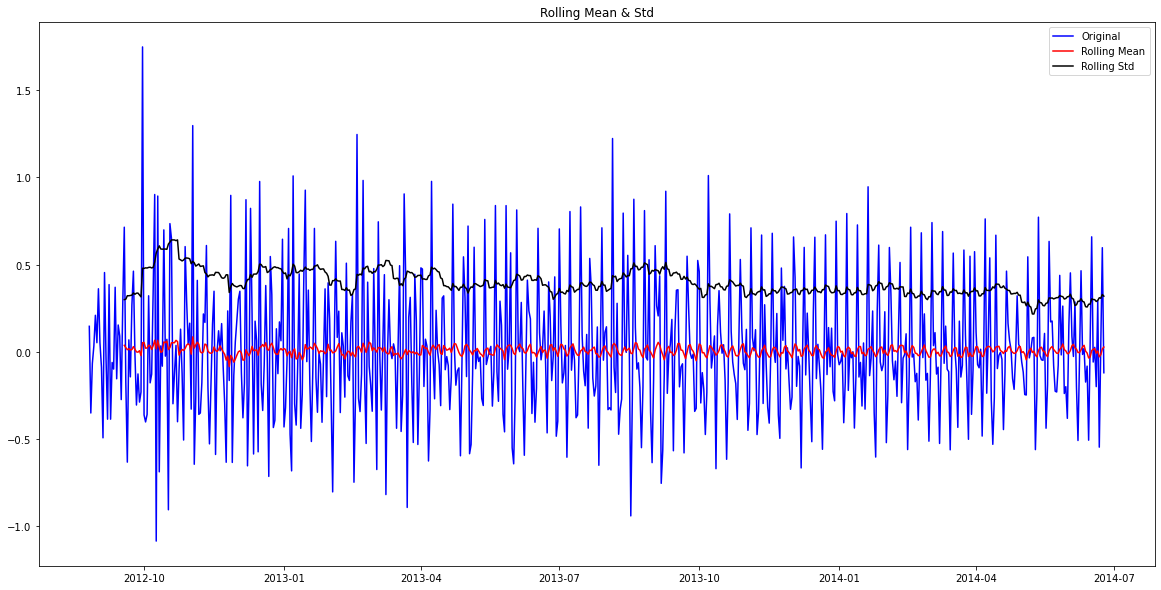

Results of Dickey-fuller tests:
Test Statistic         -8.237568e+00
p-value                 5.834049e-13
#Lags used              1.900000e+01
No. of obs used         6.480000e+02
Critical Value (1%)    -3.440482e+00
Critical Value (5%)    -2.866011e+00
Critical Value (10%)   -2.569151e+00
dtype: float64


In [41]:
# stabilising the mean of the time-series
Train_log_diff= Train_log- Train_log.shift(1)
test_stationarity(Train_log_diff.dropna())

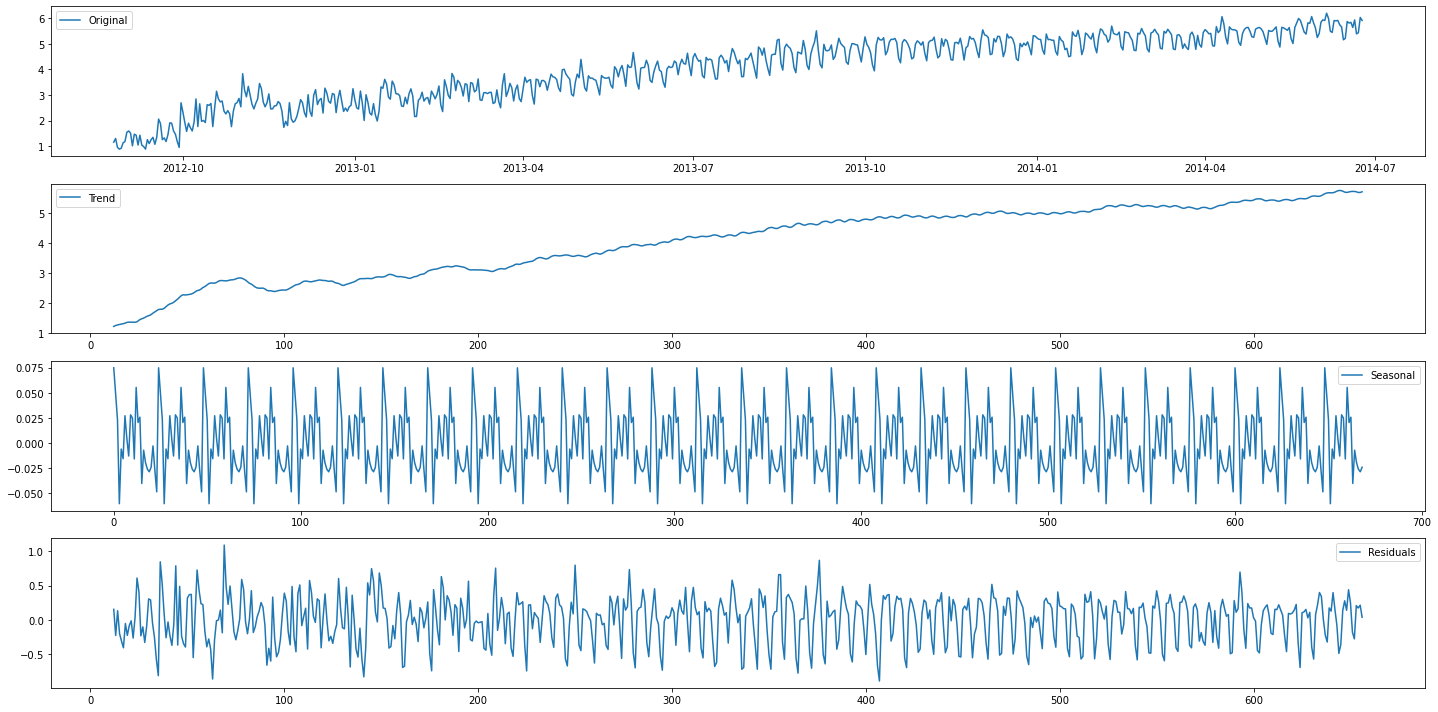

In [42]:
# Removing Seasonality by decomposing time-series into trend, seasonality and residuals
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition= seasonal_decompose(pd.DataFrame(Train_log).Count.values, freq=24)
trend= decomposition.trend
seasonal= decomposition.seasonal
residual= decomposition.resid

plt.subplot(411)
plt.plot(Train_log, label= 'Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label= 'Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label= 'Seasonal')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label= 'Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

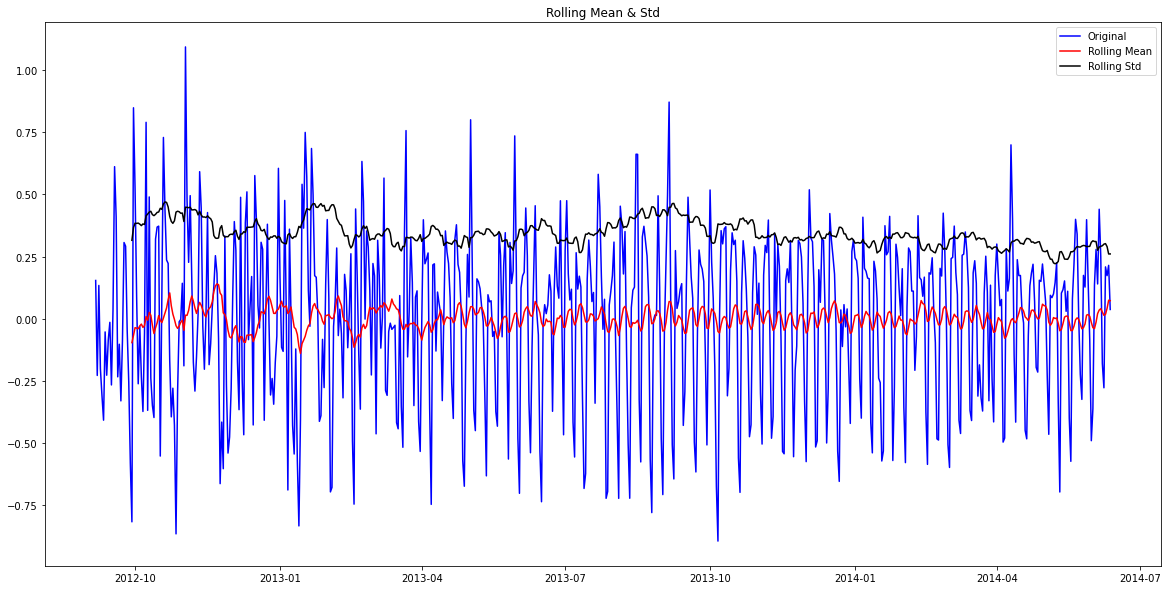

Results of Dickey-fuller tests:
Test Statistic         -7.822096e+00
p-value                 6.628321e-12
#Lags used              2.000000e+01
No. of obs used         6.240000e+02
Critical Value (1%)    -3.440873e+00
Critical Value (5%)    -2.866183e+00
Critical Value (10%)   -2.569243e+00
dtype: float64


In [43]:
# checking stationarity of residuals
Train_log_decompose= pd.DataFrame(residual)
Train_log_decompose['Date']= Train_log.index
Train_log_decompose.set_index('Date', inplace= True)
Train_log_decompose.dropna(inplace= True)
test_stationarity(Train_log_decompose[0])

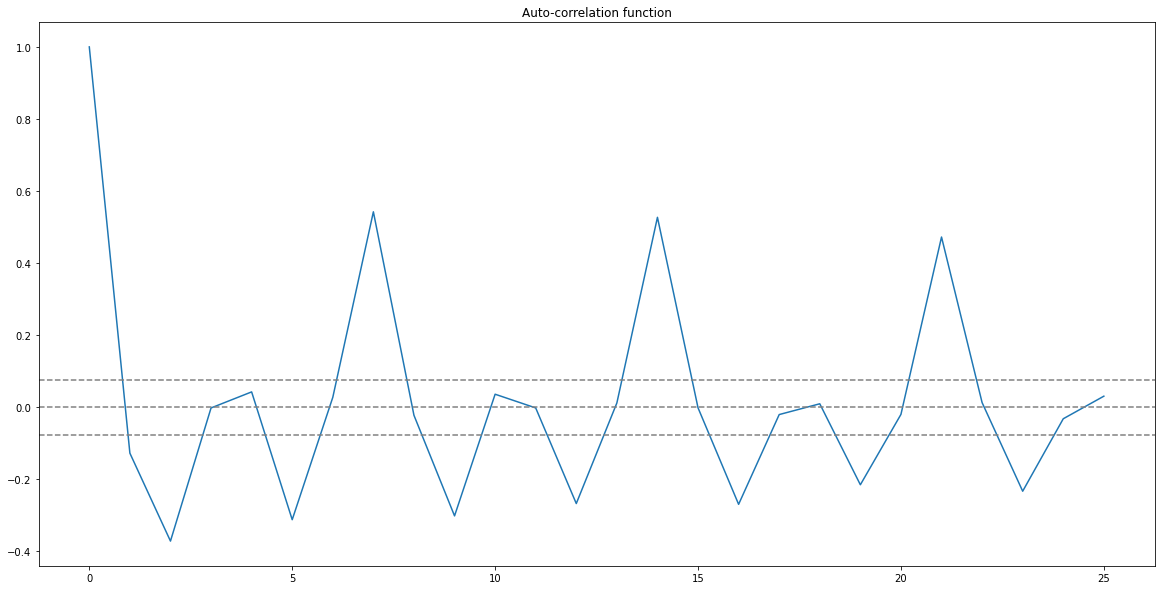

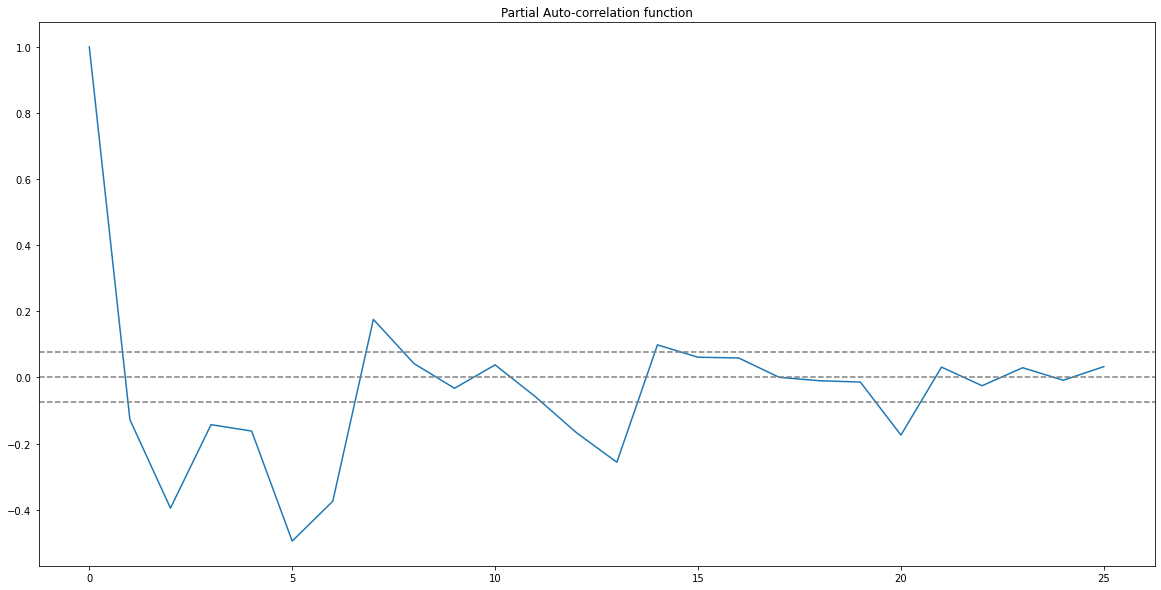

In [44]:
# finding optimised values of p,d,q parameters using Auto-correlation and Partial-auto-correlation plots
from statsmodels.tsa.stattools import acf, pacf

lag_acf= acf(Train_log_diff.dropna(), nlags=25)
lag_pacf= pacf(Train_log_diff.dropna(), nlags=25, method='ols')

plt.plot(lag_acf)
plt.axhline(y=0, linestyle= '--', color= 'gray')
plt.axhline(y= -1.96/ np.sqrt(len(Train_log_diff.dropna())), linestyle= '--', color= 'gray')
plt.axhline(y= 1.96/ np.sqrt(len(Train_log_diff.dropna())), linestyle= '--', color= 'gray')
plt.title('Auto-correlation function')
plt.show()

plt.plot(lag_pacf)
plt.axhline(y=0, linestyle= '--', color= 'gray')
plt.axhline(y= -1.96/ np.sqrt(len(Train_log_diff.dropna())), linestyle= '--', color= 'gray')
plt.axhline(y= 1.96/ np.sqrt(len(Train_log_diff.dropna())), linestyle= '--', color= 'gray')
plt.title('Partial Auto-correlation function')
plt.show()

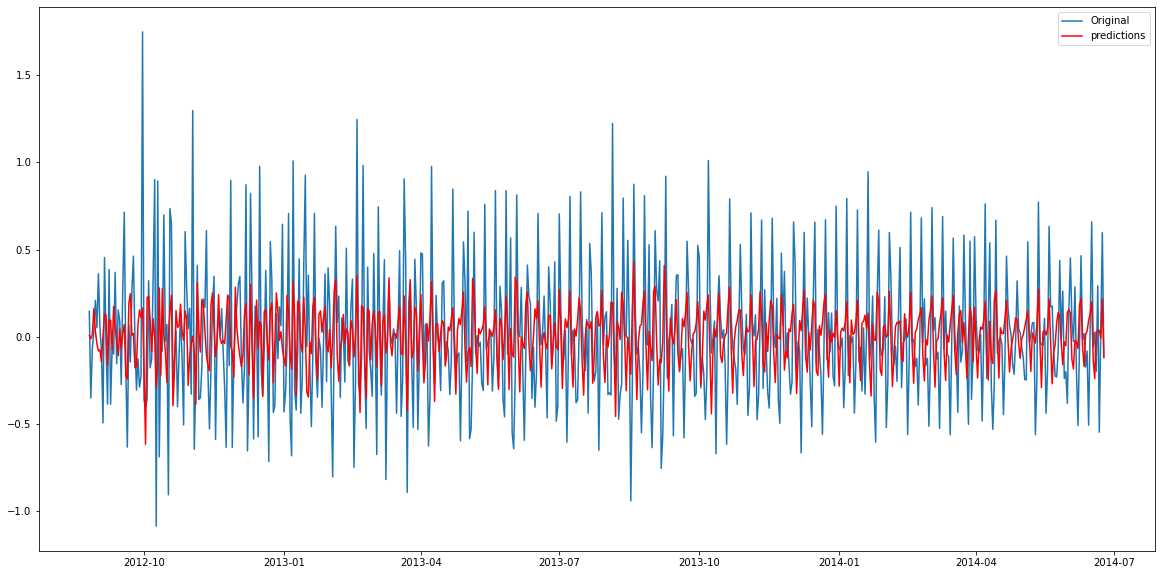

In [46]:
# AR model
from statsmodels.tsa.arima_model import ARIMA

model= ARIMA(Train_log, order= (2,1,0))    # q=0 since it only AR model
results_AR= model.fit(disp=-1)
plt.plot(Train_log_diff.dropna(), label= 'Original')
plt.plot(results_AR.fittedvalues, color='red', label= 'predictions')
plt.legend(loc='best')
plt.show()

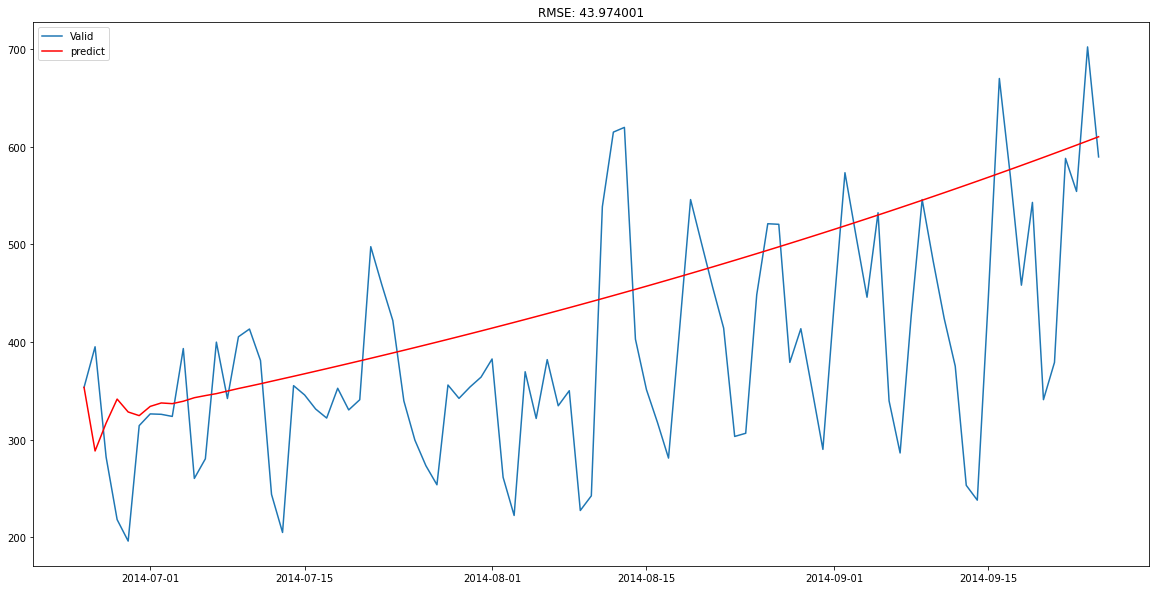

In [48]:
# plotting validation curve for AR model

AR_predict= results_AR.predict(start='2014-06-25', end='2014-09-25')
AR_predict= AR_predict.cumsum().shift().fillna(0)
AR_predict1= pd.Series(np.ones(Valid.shape[0]) * np.log(Valid['Count'])[0], index= Valid.index)
AR_predict1= AR_predict1.add(AR_predict, fill_value= 0)
AR_predict= np.exp(AR_predict1)

plt.plot(Valid['Count'], label= 'Valid')
plt.plot(AR_predict, label= 'predict', color='red')
plt.legend(loc='best')
plt.title('RMSE: %4f' % (np.sqrt(np.dot(AR_predict, Valid['Count']))/ Valid.shape[0]))
plt.show()

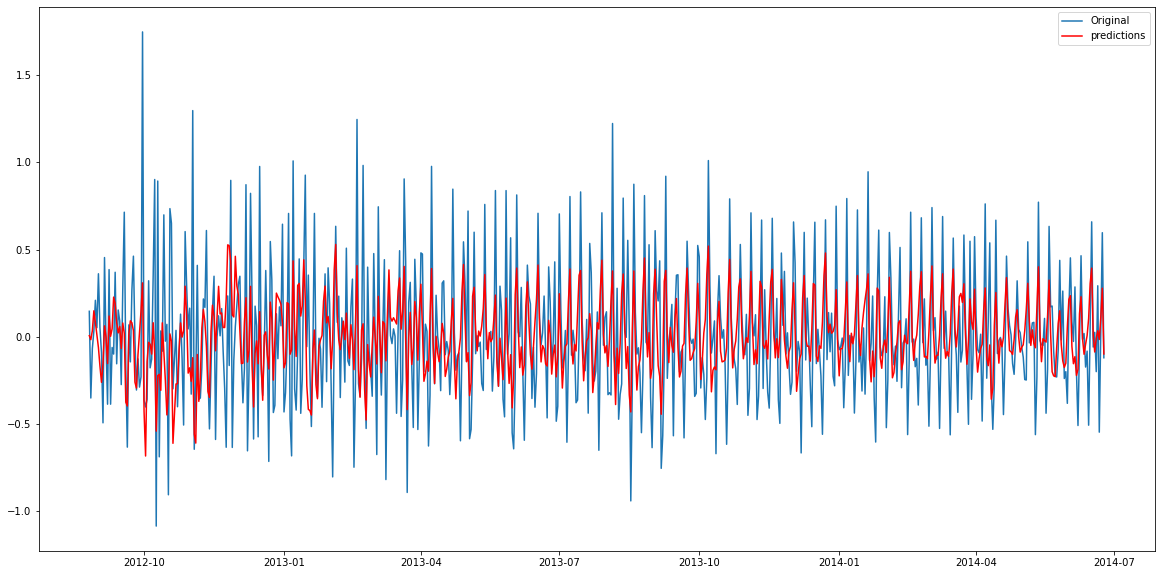

In [49]:
# MA model
model= ARIMA(Train_log, order= (0,1,2))    # p=0 since it only MA model
results_MA= model.fit(disp=-1)
plt.plot(Train_log_diff.dropna(), label= 'Original')
plt.plot(results_MA.fittedvalues, color='red', label= 'predictions')
plt.legend(loc='best')
plt.show()

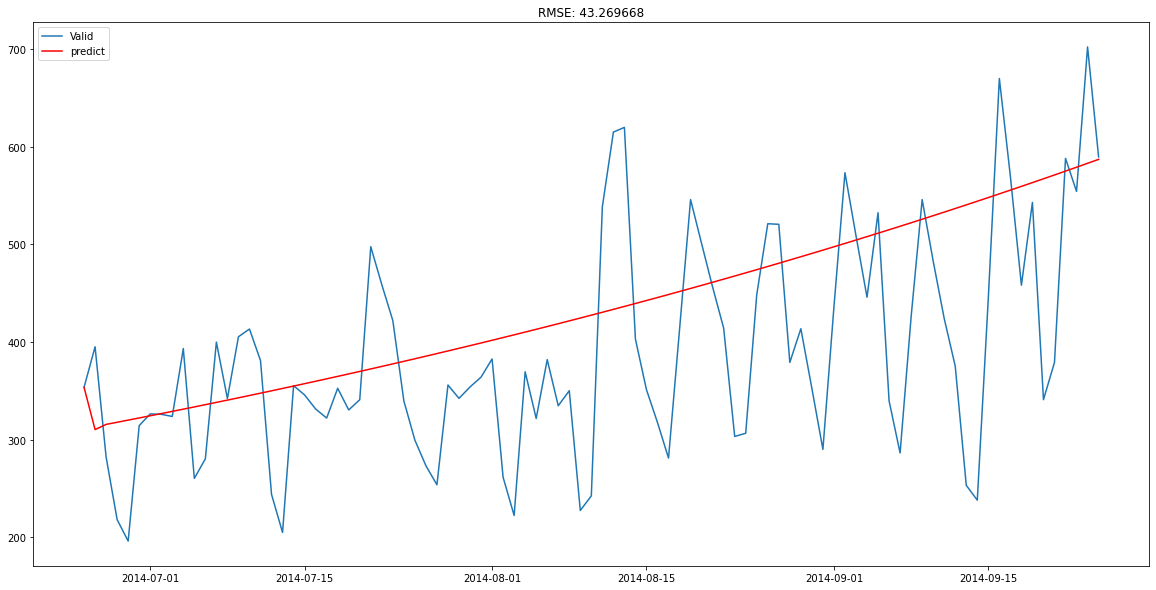

In [50]:
# plotting validation curve for MA model

MA_predict= results_MA.predict(start='2014-06-25', end='2014-09-25')
MA_predict= MA_predict.cumsum().shift().fillna(0)
MA_predict1= pd.Series(np.ones(Valid.shape[0]) * np.log(Valid['Count'])[0], index= Valid.index)
MA_predict1= MA_predict1.add(MA_predict, fill_value= 0)
MA_predict= np.exp(MA_predict1)

plt.plot(Valid['Count'], label= 'Valid')
plt.plot(MA_predict, label= 'predict', color='red')
plt.legend(loc='best')
plt.title('RMSE: %4f' % (np.sqrt(np.dot(MA_predict, Valid['Count']))/ Valid.shape[0]))
plt.show()

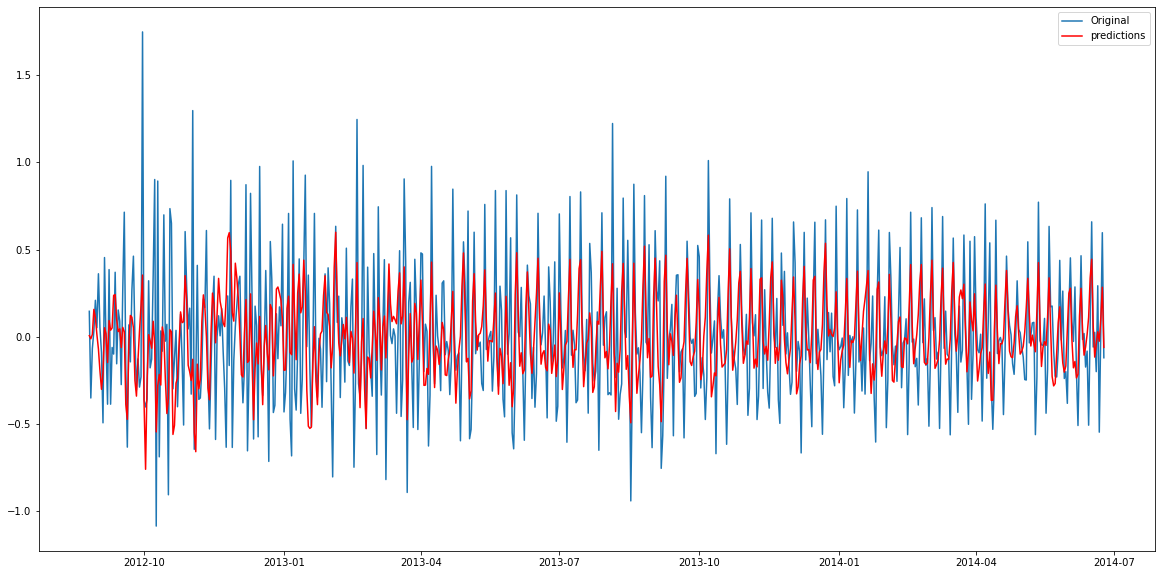

In [52]:
# Combined model (ARIMA)

model= ARIMA(Train_log, order= (2,1,2))
results_ARIMA= model.fit(disp=-1)
plt.plot(Train_log_diff.dropna(), label= 'Original')
plt.plot(results_ARIMA.fittedvalues, color='red', label= 'predictions')
plt.legend(loc='best')
plt.show()

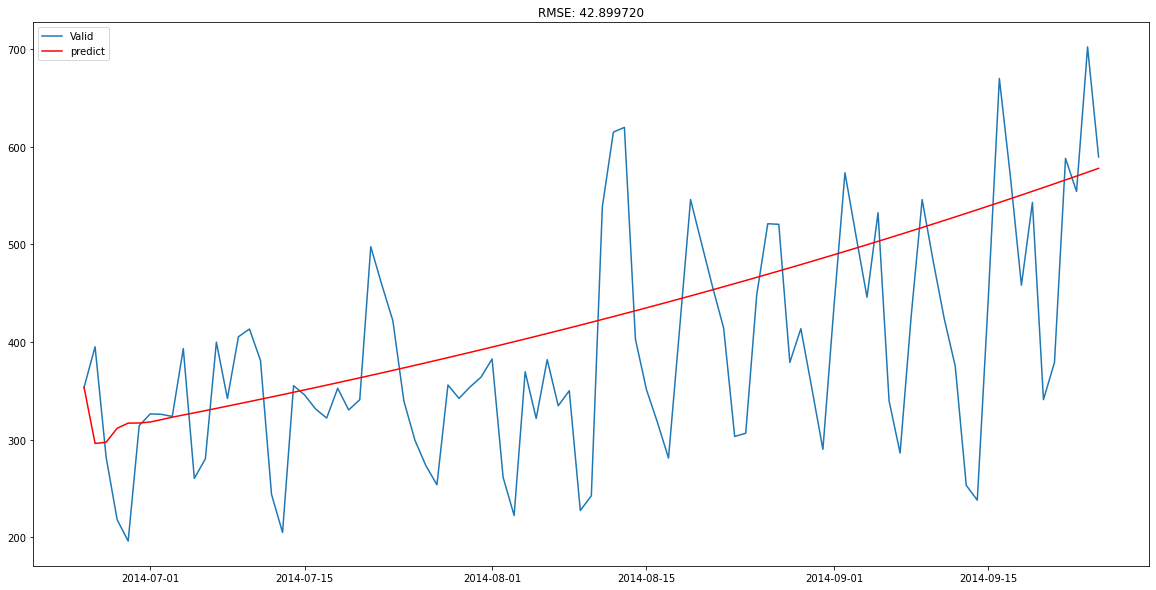

In [53]:
# plotting validation curve for ARIMA model

ARIMA_predict= results_ARIMA.predict(start='2014-06-25', end='2014-09-25')
ARIMA_predict= ARIMA_predict.cumsum().shift().fillna(0)
ARIMA_predict1= pd.Series(np.ones(Valid.shape[0]) * np.log(Valid['Count'])[0], index= Valid.index)
ARIMA_predict1= ARIMA_predict1.add(ARIMA_predict, fill_value= 0)
ARIMA_predict= np.exp(ARIMA_predict1)

plt.plot(Valid['Count'], label= 'Valid')
plt.plot(ARIMA_predict, label= 'predict', color='red')
plt.legend(loc='best')
plt.title('RMSE: %4f' % (np.sqrt(np.dot(ARIMA_predict, Valid['Count']))/ Valid.shape[0]))
plt.show()

C:\Users\Aditi Sony\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


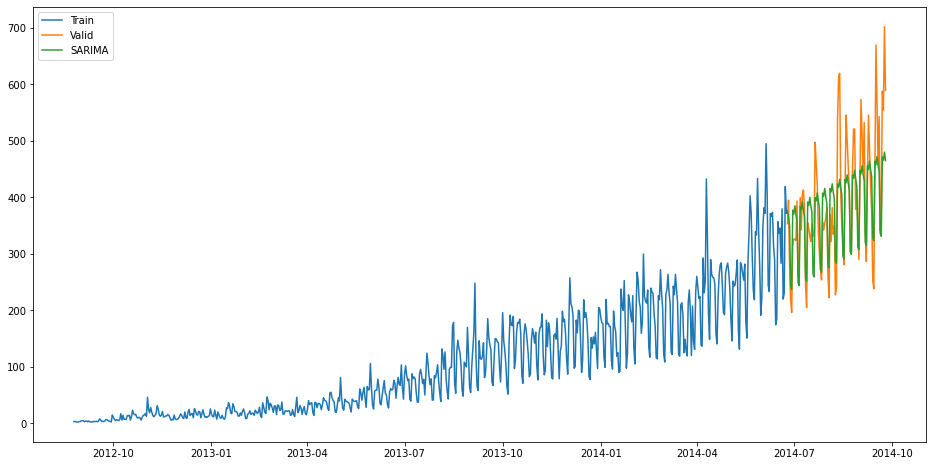

In [54]:
# SARIMAX model

y_hat_avg= Valid.copy()
fit1= sm.tsa.statespace.SARIMAX(Train.Count, order= (2,1,4), seasonal_order=(0,1,1,7)).fit()
y_hat_avg['SARIMA']= fit1.predict(start='2014-06-25', end='2014-09-25', dynamic= True)
plt.figure(figsize=(16,8))
plt.plot(Train['Count'], label= 'Train')
plt.plot(Valid['Count'], label= 'Valid')
plt.plot(y_hat_avg['SARIMA'], label= 'SARIMA')
plt.legend(loc= 'best')
plt.show()

In [55]:
rms= sqrt(mean_squared_error(Valid.Count, y_hat_avg['SARIMA']))
print(rms)

69.98255371173184
